# 📌 1️⃣ Install Dependencies

In [1]:
!pip install tensorflow numpy pandas opencv-python matplotlib tqdm scikit-learn albumentations

# 📌 2️⃣ Import Necessary Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import shutil
import random

2025-04-30 17:10:44.347585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746033044.539247      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746033044.595214      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 📌 3️⃣ Load and Inspect Dataset

In [3]:
dataset_path = "/kaggle/input/Data Files"

#DEFINE CLASS LABELS
class_labels = ["NONANNOTATEDAMD", "NONANNOTATEDDME", "NORMAL"]

#DATASET STRUCTURE
for folder in class_labels:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} images")

NONANNOTATEDAMD: 77 images
NONANNOTATEDDME: 745 images
NORMAL: 218 images


# 🔍 Sample Original Images (3 Per Class)

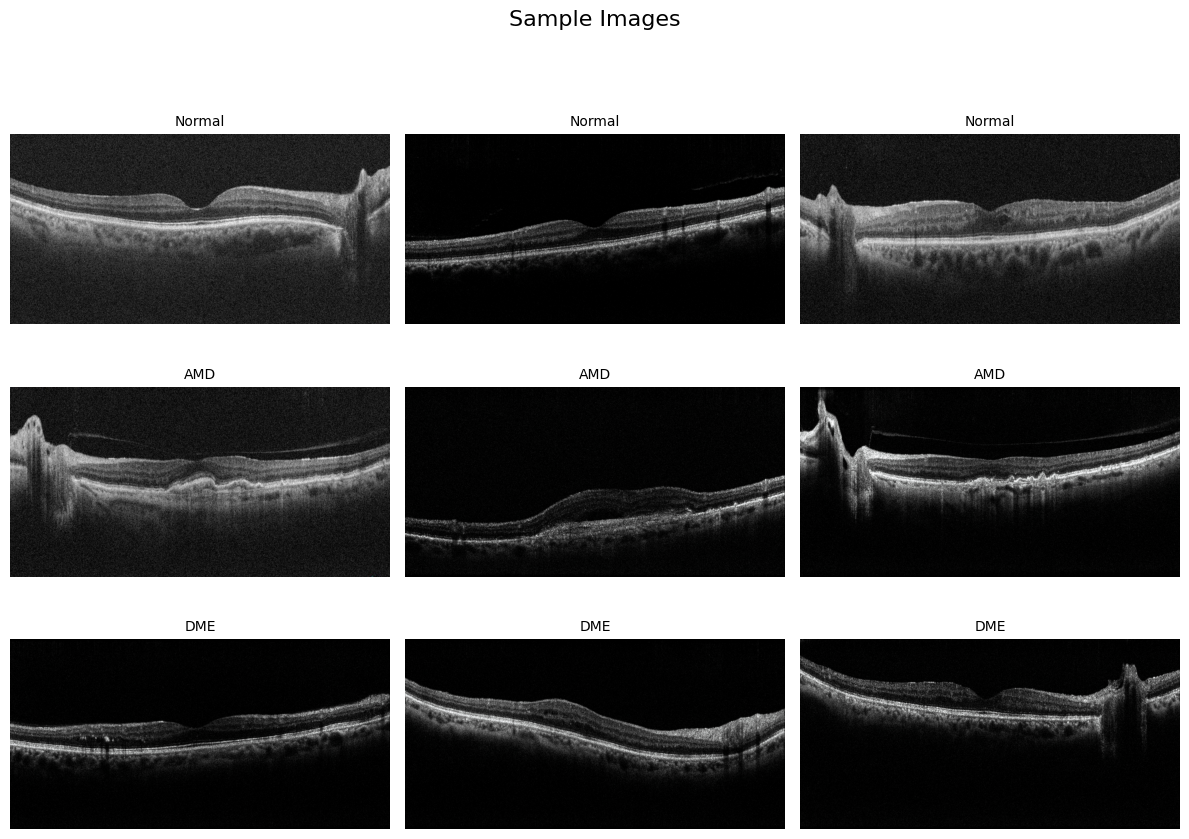

In [4]:
class_labels = ["NORMAL", "NONANNOTATEDAMD", "NONANNOTATEDDME"]
display_labels = {"NORMAL": "Normal", "NONANNOTATEDAMD": "AMD", "NONANNOTATEDDME": "DME"}
dataset_path = "/kaggle/input/Data Files"  

fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(display_labels[folder], fontsize=10)

plt.suptitle("Sample Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 📌 4️⃣ Preprocess Dataset

In [5]:
TARGET_SIZE = (224, 224)  
preprocessed_path = "/kaggle/working/Preprocessed_Data"
os.makedirs(preprocessed_path, exist_ok=True)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return None
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    resized_img = cv2.resize(img, TARGET_SIZE)
    return resized_img

for folder in class_labels:
    folder_path = os.path.join(dataset_path, folder)
    save_folder = os.path.join(preprocessed_path, folder)
    os.makedirs(save_folder, exist_ok=True)

    for img_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
        img_path = os.path.join(folder_path, img_name)
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            save_path = os.path.join(save_folder, img_name)
            cv2.imwrite(save_path, processed_img)

print("Preprocessing complete.")

Processing NONANNOTATEDDME: 100%|██████████| 745/745 [00:13<00:00, 54.79it/s]

Preprocessing complete.


# 🔍 Sample Preprocessed Images (3 Per Class)

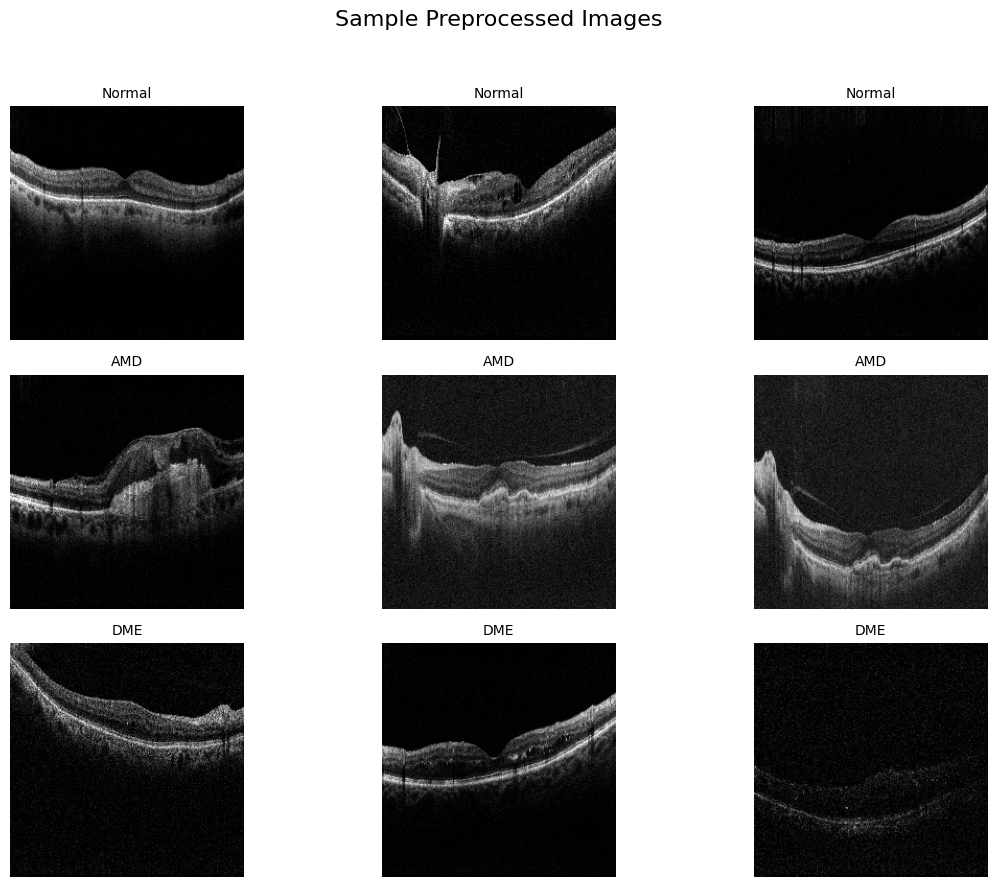

In [6]:
class_labels = ["NORMAL", "NONANNOTATEDAMD", "NONANNOTATEDDME"]
display_labels = {"NORMAL": "Normal", "NONANNOTATEDAMD": "AMD", "NONANNOTATEDDME": "DME"}

fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(preprocessed_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(display_labels[folder], fontsize=10)

plt.suptitle("Sample Preprocessed Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 📌 5️⃣ Augmentation (To Reach 1500 Per Class)

In [7]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Blur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5)
])

augmented_classes = {
    "NONANNOTATEDAMD": 1500 - 77,
    "NONANNOTATEDDME": 1500 - 745,
    "NORMAL": 1500 - 218
}

for category, num_augments in augmented_classes.items():
    folder_path = os.path.join(preprocessed_path, category)
    original_images = os.listdir(folder_path)

    print(f"Augmenting {num_augments} images for {category}")

    for i in tqdm(range(num_augments)):
        img_name = random.choice(original_images)
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        augmented_img = augmentation(image=img)["image"]
        save_path = os.path.join(folder_path, f"aug_{i}_{img_name}")
        cv2.imwrite(save_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

print("Augmentation complete. All classes now have 1500 images.")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmenting 1423 images for NONANNOTATEDAMD


100%|██████████| 1423/1423 [00:02<00:00, 665.79it/s]


Augmenting 755 images for NONANNOTATEDDME


100%|██████████| 755/755 [00:01<00:00, 657.15it/s]


Augmenting 1282 images for NORMAL


100%|██████████| 1282/1282 [00:01<00:00, 641.08it/s]

Augmentation complete. All classes now have 1500 images.


# 🔍 Inspect and Ensure Final Count

In [8]:
for folder in class_labels:
    folder_path = os.path.join(preprocessed_path, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} images")

NORMAL: 1500 images
NONANNOTATEDAMD: 1500 images
NONANNOTATEDDME: 1500 images


# 🔍 View Sample Augmented Images

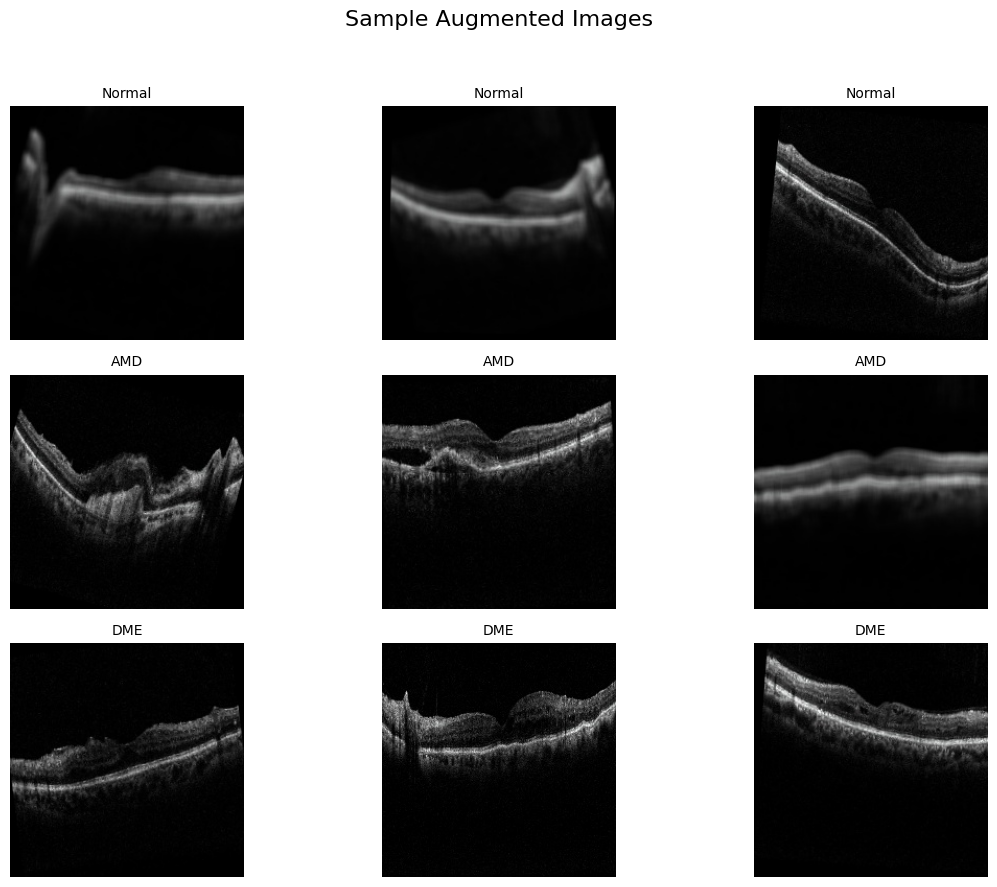

In [9]:
class_labels = ["NORMAL", "NONANNOTATEDAMD", "NONANNOTATEDDME"]
display_labels = {"NORMAL": "Normal", "NONANNOTATEDAMD": "AMD", "NONANNOTATEDDME": "DME"}

fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(preprocessed_path, folder)
    images = [img for img in os.listdir(folder_path) if img.startswith("aug_")]
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(display_labels[folder], fontsize=10)

plt.suptitle("Sample Augmented Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 📌 6️⃣ Segmentation (Generate Threshold-Based Simulated Masks)

In [10]:
segmentation_masks_path = "/kaggle/working/Segmentation_Masks"
os.makedirs(segmentation_masks_path, exist_ok=True)

#CLASS LABELS FOR NON-ANNOTATED DME, AMD, AND NORMAL
class_labels = ["NONANNOTATEDAMD", "NONANNOTATEDDME", "NORMAL"]

for folder in class_labels:
    mask_folder = os.path.join(segmentation_masks_path, folder)
    os.makedirs(mask_folder, exist_ok=True)

    image_folder = os.path.join(preprocessed_path, folder)
    
    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        #SIMULATED SEGMENTATION USING SIMPLE INTENSITY THRESHOLD
        _, mask = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)

        mask_path = os.path.join(mask_folder, img_name)
        cv2.imwrite(mask_path, mask)

print("Segmentation masks created using intensity thresholding for NONANNOTATEDDME, NONANNOTATEDAMD, and NORMAL.")

Segmentation masks created using intensity thresholding for NONANNOTATEDDME, NONANNOTATEDAMD, and NORMAL.


# 🔍 Sample Segmentation Masks (3 Per Class)

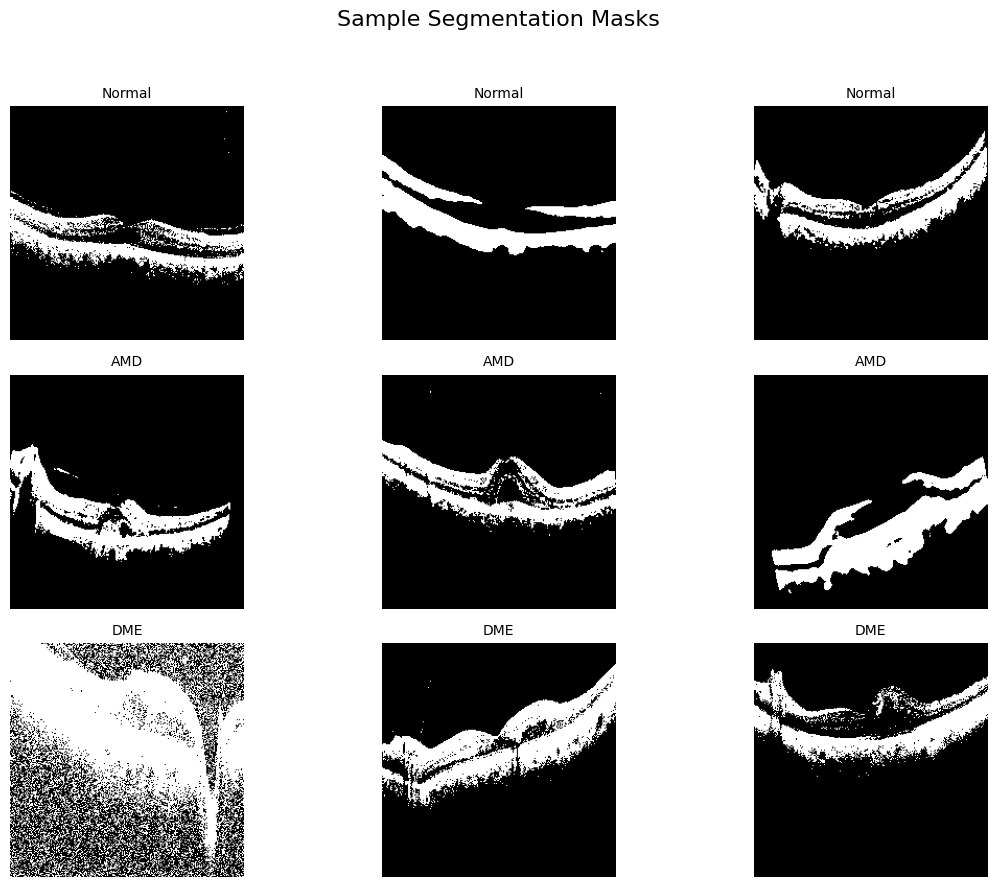

In [11]:
class_labels = ["NORMAL", "NONANNOTATEDAMD", "NONANNOTATEDDME"]
display_labels = {"NORMAL": "Normal", "NONANNOTATEDAMD": "AMD", "NONANNOTATEDDME": "DME"}

fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(segmentation_masks_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[row, col].imshow(mask, cmap="gray")
        axes[row, col].axis("off")
        axes[row, col].set_title(display_labels[folder], fontsize=10)

plt.suptitle("Sample Segmentation Masks", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 📌 7️⃣ Train, Validation, and Test Split

In [12]:
import os
import shutil
import numpy as np

#RATIOS
train_ratio, val_ratio, test_ratio = 0.60, 0.20, 0.20

#DEFINE DIRECTORIES FOR TRAIN, VALIDATION, AND TEST SETS
train_path = os.path.join(preprocessed_path, "train")
val_path = os.path.join(preprocessed_path, "val")
test_path = os.path.join(preprocessed_path, "test")


for path in [train_path, val_path, test_path]:
    os.makedirs(path, exist_ok=True)

def split_dataset(folder):
    file_list = os.listdir(os.path.join(preprocessed_path, folder))
    np.random.shuffle(file_list)
    
    train_idx = int(len(file_list) * train_ratio)
    val_idx = int(len(file_list) * (train_ratio + val_ratio))
    
    return file_list[:train_idx], file_list[train_idx:val_idx], file_list[val_idx:]

class_labels = ["NONANNOTATEDAMD", "NONANNOTATEDDME", "NORMAL"]
for folder in class_labels:
    os.makedirs(os.path.join(train_path, folder), exist_ok=True)
    os.makedirs(os.path.join(val_path, folder), exist_ok=True)
    os.makedirs(os.path.join(test_path, folder), exist_ok=True)

    train_files, val_files, test_files = split_dataset(folder)

    for file in train_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(train_path, folder, file))
    for file in val_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(val_path, folder, file))
    for file in test_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(test_path, folder, file))

print("Data split and moved to train/val/test folders successfully.")

Data split and moved to train/val/test folders successfully.


# 📌 8️⃣ Define Data Generators

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#CREATE IMAGEGENERATOR
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2700 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# 📌 9️⃣ Define Model

In [14]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

base_model = ResNet152(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(class_labels), activation="softmax")(x)  #MULTI-CLASS CLASSIFICATION

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

#SAVE BEST MODEL
model_save_path = "/kaggle/working/best_resnet152_model.keras"

checkpoint = ModelCheckpoint(
    model_save_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)
model.summary()

I0000 00:00:1746033094.402393      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 58,896,259 (224.67 MB)

 Trainable params: 58,744,835 (224.09 MB)

 Non-trainable params: 151,424 (591.50 KB)

# 📌 🔟 Train Model

In [15]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746033244.654225      85 service.cc:148] XLA service 0x7eb39c002660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746033244.655111      85 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746033257.663463      85 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746033295.117540      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.6561 - loss: 0.7629
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /kaggle/working/best_resnet152_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.6576 - loss: 0.7598 - val_accuracy: 0.3333 - val_loss: 3.1342
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9374 - loss: 0.1597
Epoch 2: val_accuracy did not improve from 0.33333
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 413ms/step - accuracy: 0.9375 - loss: 0.1595 - val_accuracy: 0.3333 - val_loss: 6.9604
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9717 - loss: 0.0912
Epoch 3: val_accuracy did not improve from 0.33333
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 414ms/step - accuracy: 0.9717 - loss: 0.0911 - val_accuracy: 0.3333 - val_loss: 6.8361
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9802 - loss: 0.0616
Epoch 4: val_accuracy improved from 0.33333 to 0.33444, saving model to /kaggle/working/best_resnet15

# 🔍 Training and Validation Curves

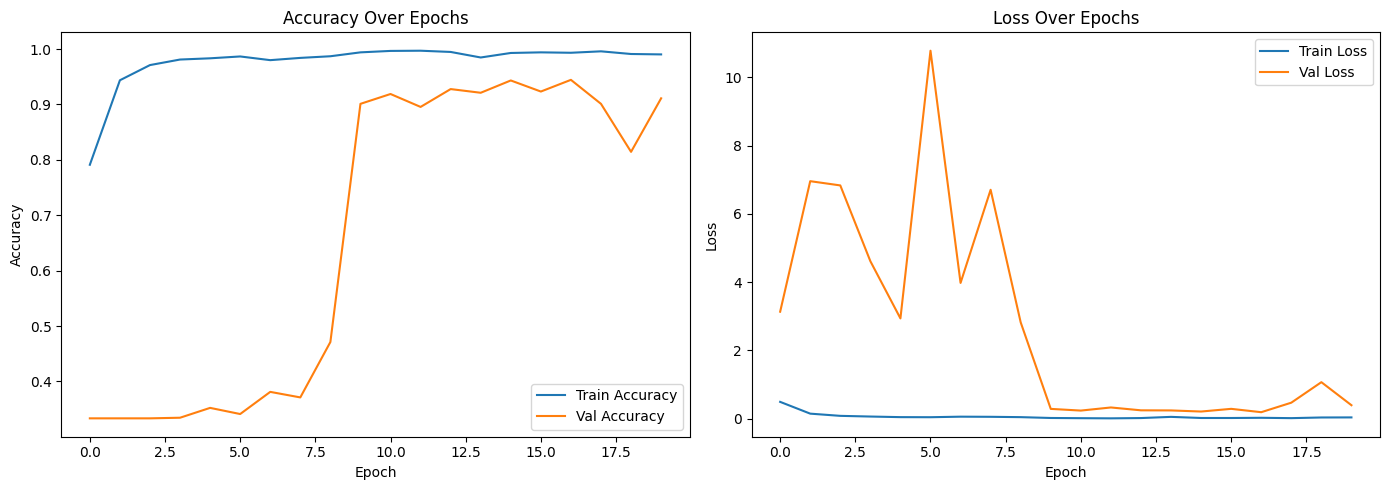

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

#ACCURACY
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#LOSS
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 📌 1️⃣1️⃣ Evaluate the Best Model on Test Set

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

model_save_path = "/kaggle/working/best_resnet152_model.keras" 
best_model = load_model(model_save_path)


y_pred = np.argmax(best_model.predict(test_generator), axis=1)  
y_true = test_generator.classes  

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
print("\nAccuracy:", accuracy_score(y_true, y_pred))

Found 900 images belonging to 3 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step

Classification Report:
                  precision    recall  f1-score   support

NONANNOTATEDAMD       0.99      0.99      0.99       300
NONANNOTATEDDME       0.89      0.96      0.92       300
         NORMAL       0.96      0.88      0.92       300

       accuracy                           0.95       900
      macro avg       0.95      0.95      0.95       900
   weighted avg       0.95      0.95      0.95       900


Accuracy: 0.9455555555555556


# 📌 1️⃣2️⃣ Setting Explainble AI ( Grad-CAM )

In [18]:
for layer in model.layers:
    print(layer.name)

input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co

# 📌 1️⃣3️⃣ Apply Explainable AI

Selected Augmented Images (10 per class):

DME:
  - aug_718_11260.jpg
  - aug_237_12152.jpg
  - aug_675_10649.jpg
  - aug_101_14975.jpg
  - aug_87_6821.jpg
  - aug_399_10119.jpg
  - aug_434_162.jpg
  - aug_189_19414.jpg
  - aug_512_10268.jpg
  - aug_445_10355.jpg

AMD:
  - aug_1092_22446.jpg
  - aug_63_22442.jpg
  - aug_463_14365.jpg
  - aug_466_22446.jpg
  - aug_776_1264.jpg
  - aug_120_10362.jpg
  - aug_465_1584.jpg
  - aug_85_22453.jpg
  - aug_354_11677.jpg
  - aug_641_22461.jpg

Normal:
  - aug_1243_10773.jpg
  - aug_527_1063.jpg
  - aug_374_13017.jpg
  - aug_1065_10086.jpg
  - aug_434_11152.jpg
  - aug_753_11149.jpg
  - aug_995_236.jpg
  - aug_81_1060.jpg
  - aug_893_8365.jpg
  - aug_607_11499.jpg
Saving Combined Original+GradCAM Outputs with Labels...
All outputs saved and zipped to GradCAM_Output.zip.


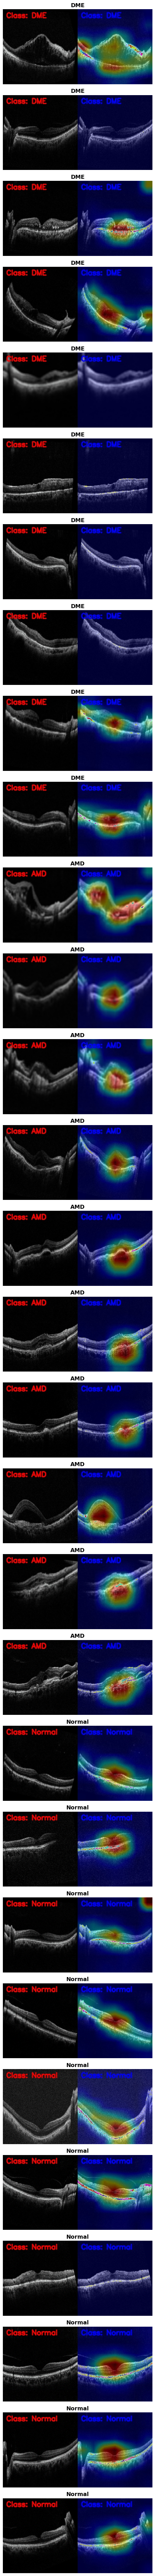

In [19]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import shutil
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

#CONFIGURATION
base_path = '/kaggle/working/Preprocessed_Data/train'
classes = ['NONANNOTATEDDME', 'NONANNOTATEDAMD', 'NORMAL']
class_map = {'NONANNOTATEDDME': 'DME', 'NONANNOTATEDAMD': 'AMD', 'NORMAL': 'Normal'}
images_per_class = 10
last_conv_layer_name = 'conv5_block3_out'

#OUTPUT FOLDER
output_base = '/kaggle/working/GradCAM_Output'
os.makedirs(output_base, exist_ok=True)

#SELECT AUGMENTED IMAGES
selected_images = []
print("Selected Augmented Images (10 per class):")
for cls in classes:
    class_path = os.path.join(base_path, cls)
    filenames = [f for f in os.listdir(class_path) if f.startswith('aug_') and f.endswith('.jpg')]
    
    if len(filenames) < images_per_class:
        print(f"Not enough augmented images in {cls}. Available: {len(filenames)}")
        continue

    chosen = random.sample(filenames, images_per_class)
    print(f"\n{class_map[cls]}:")
    for f in chosen:
        print(f"  - {f}")
    selected_images.extend([(os.path.join(class_path, f), cls) for f in chosen])

#GRAD-CAM SETUP
grad_model = Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

def generate_gradcam(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    preds = model.predict(x, verbose=0)
    pred_class = np.argmax(preds[0])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = heatmap * 0.4 + img
    return cv2.cvtColor(superimposed.astype('uint8'), cv2.COLOR_BGR2RGB)

#PROCESS AND SAVE IMAGES WITH LABELS
print("Saving Combined Original+GradCAM Outputs with Labels...")
for img_path, label in selected_images:
    class_name = class_map[label]
    class_folder = os.path.join(output_base, class_name)
    os.makedirs(class_folder, exist_ok=True)

    img_name = os.path.basename(img_path)
    
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))
    gradcam_img = generate_gradcam(img_path)

    #CLASS LABELS ON IMAGES
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    color = (0, 0, 255)  
    thickness = 2
    label_text = f"Class: {class_name}"
    cv2.putText(original_img, label_text, (10, 25), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(gradcam_img, label_text, (10, 25), font, font_scale, color, thickness, cv2.LINE_AA)

    combined_img = np.hstack((original_img, cv2.cvtColor(gradcam_img, cv2.COLOR_RGB2BGR)))
    combined_path = os.path.join(class_folder, f"{class_name}_combined_{img_name}")
    cv2.imwrite(combined_path, combined_img)

#ZIP THE OUTPUT FOLDER
shutil.make_archive(output_base, 'zip', output_base)
print("All outputs saved and zipped to GradCAM_Output.zip.")

#DISPLAY THE IMAGES SIDE BY SIDE
def show_all_gradcam_outputs(output_dir, class_map, save_display_folder='Display_Images'):
    os.makedirs(save_display_folder, exist_ok=True)

    total_images_per_class = 10
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    color = (0, 0, 255)
    thickness = 2

    fig, axes = plt.subplots(nrows=30, ncols=1, figsize=(6, 90))  # 30 rows for 30 images

    idx = 0
    for internal_label, display_label in class_map.items():
        class_folder = os.path.join(output_dir, display_label)
        os.makedirs(class_folder, exist_ok=True)

        folder = os.path.join(output_dir, display_label)
        if not os.path.exists(folder):
            print(f"Folder not found: {folder}")
            continue

        files = sorted([f for f in os.listdir(folder) if f.endswith('.jpg')])
        if len(files) < total_images_per_class:
            print(f"Not enough images in {folder}. Found {len(files)}.")
            continue

        selected = random.sample(files, total_images_per_class)
        for f in selected:
            img_path = os.path.join(folder, f)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

          
            ax = axes[idx]  
            ax.imshow(img_rgb)
            ax.set_title(f"{display_label}", fontsize=14, fontweight='bold')
            ax.axis('off')  
            idx += 1

    plt.tight_layout()
    plt.show()

show_all_gradcam_outputs(output_base, class_map)